In [277]:
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

plt.style.use('dark_background')

print(torch.cuda.is_available())

True


In [278]:
data = pd.read_csv("./cleaned/usdrub.csv", index_col=0)

In [279]:
# data.to_csv('./aaa.csv', index=False)

In [280]:
data

,date,open,high,low,close,vol
33,2014-02-06,34.8934,34.9337,34.5848,34.7102,7669
34,2014-02-07,34.7300,34.8300,34.5300,34.7500,10
116,2014-05-05,35.7747,35.8635,35.6700,35.7100,1564
268,2014-10-07,39.7165,39.9751,39.6550,39.8873,376
269,2014-10-08,39.8959,40.1560,39.6877,39.9721,901
...,...,...,...,...,...,...
3404,2024-01-19,89.4213,89.5250,87.1000,88.0500,7931
3405,2024-01-21,88.0500,88.0500,88.0500,88.0500,2
3406,2024-01-22,88.0500,88.5650,86.9250,87.9932,2622
3407,2024-01-23,87.9000,88.8839,86.8250,88.6173,7594


In [281]:
from IPython.display import HTML, display

Check for stationarity

In [282]:
data['close']

33      34.7102
34      34.7500
116     35.7100
268     39.8873
269     39.9721
         ...   
3404    88.0500
3405    88.0500
3406    87.9932
3407    88.6173
3408    88.2400
Name: close, Length: 3122, dtype: float64

In [283]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.788866647615692
p-value: 0.05988177088603723
Critial Values:
   1%, -3.4324646145004256
Critial Values:
   5%, -2.862474304424197
Critial Values:
   10%, -2.567267353018705


Autocorrelations

In [284]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1600x700 with 0 Axes>

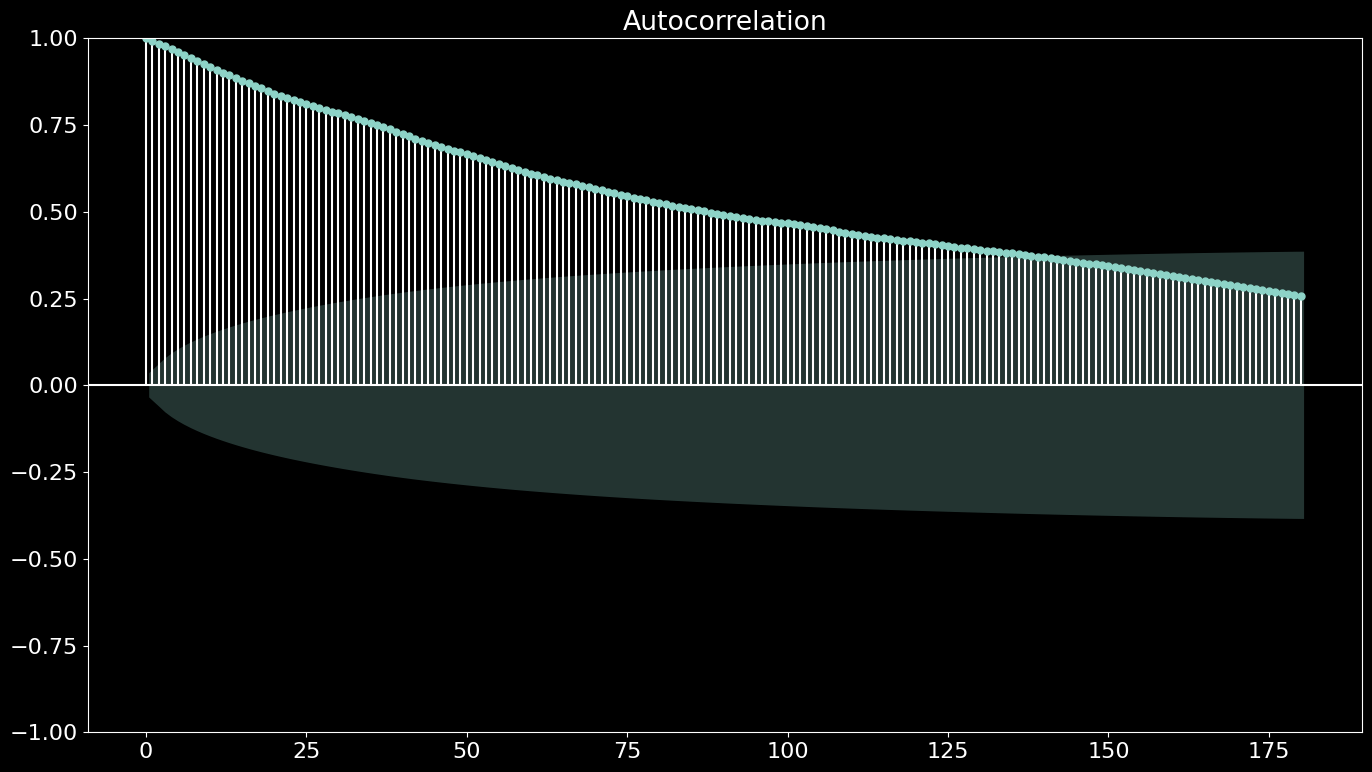

In [285]:
plt.figure(figsize=(16,7))
plot_acf(data['close'], fft=True, lags=180)
plt.tight_layout()
plt.show()

<Figure size 1600x700 with 0 Axes>

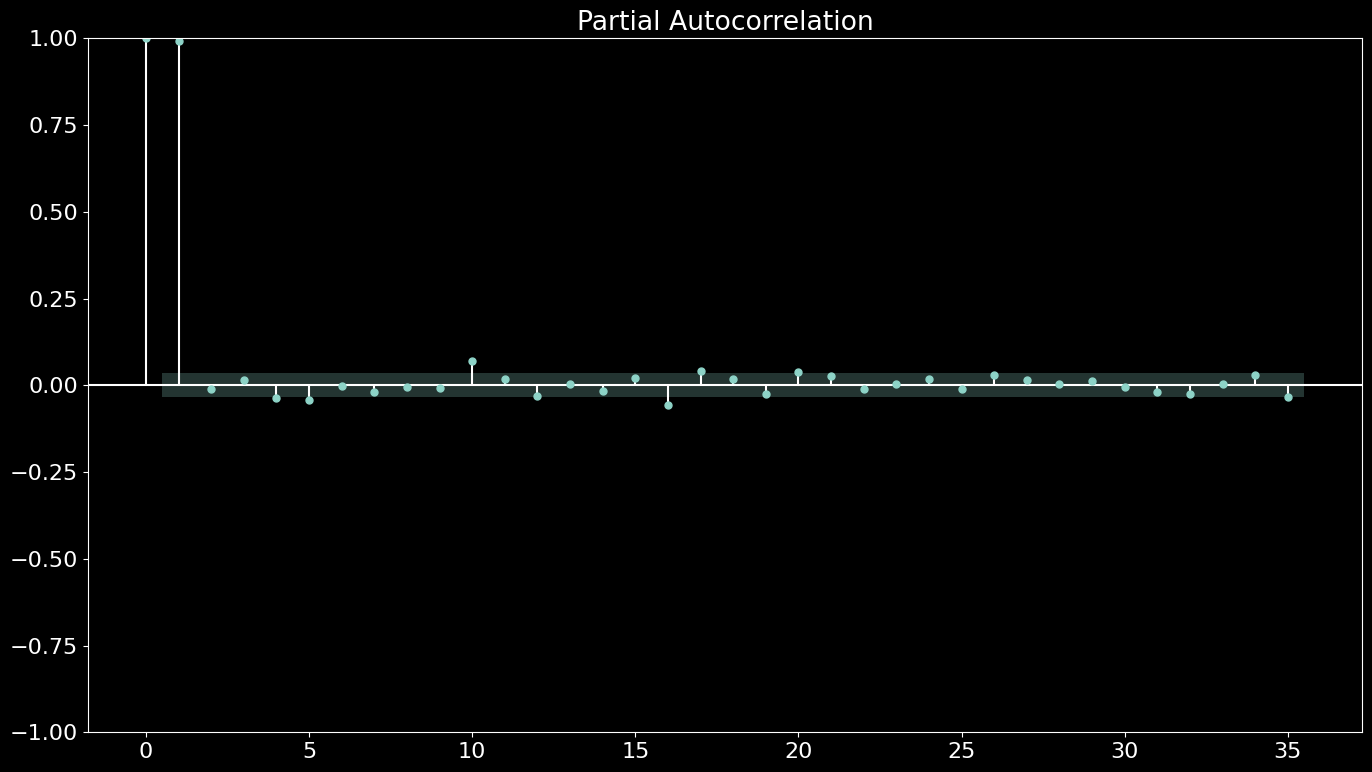

In [286]:
plt.figure(figsize=(16,7))
plot_pacf(data['close'])
plt.tight_layout()
plt.show()

Train test split and preparation

In [287]:
data = data.set_index('date')

In [288]:
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  2497
Shape of Train and Test data:  2497 625


In [289]:
from numpy import array

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [290]:
lag = 7  # Empirically we have choosen
n_features = 1

In [291]:
train_X, train_y = split_sequence(train_data['close'], lag)
test_X, test_y = split_sequence(test_data['close'], lag)

C:\Users\igor\AppData\Local\Temp\ipykernel_21872\1544843132.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


In [292]:
train_X

array([[34.7102, 34.75  , 35.71  , ..., 39.9721, 43.0322, 43.0233],
       [34.75  , 35.71  , 39.8873, ..., 43.0322, 43.0233, 43.5873],
       [35.71  , 39.8873, 39.9721, ..., 43.0233, 43.5873, 43.5678],
       ...,
       [74.7813, 74.7545, 74.549 , ..., 76.6961, 76.2934, 75.7251],
       [74.7545, 74.549 , 75.2994, ..., 76.2934, 75.7251, 75.5988],
       [74.549 , 75.2994, 76.6961, ..., 75.7251, 75.5988, 74.764 ]])

In [293]:
train_y

array([43.5873, 43.5678, 44.9   , ..., 75.5988, 74.764 , 74.384 ])

In [294]:
train_X.shape, train_y.shape

((2490, 7), (2490,))

In [295]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [296]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (2490, 7, 1) (2490,)
Shape of test_X and test_y:  (618, 7, 1) (618,)


Model

In [297]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [298]:
# # ok params
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [299]:
history = model.fit(train_X, train_y, epochs = 15, batch_size=8, verbose=1, validation_split= 0.1)

Epoch 1/15


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1538.4772 - val_loss: 0.4453
Epoch 2/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2648 - val_loss: 0.3127
Epoch 3/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1144 - val_loss: 0.3091
Epoch 4/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9923 - val_loss: 0.9731
Epoch 5/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9843 - val_loss: 0.7240
Epoch 6/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8517 - val_loss: 0.2527
Epoch 7/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9619 - val_loss: 0.2393
Epoch 8/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0045 - val_loss: 2.2471
Epoch 9/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3370 - val_loss: 0.2252
Epoch 10/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7549 - val_loss: 0.2433
Epoch 11/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8764 - val_loss: 1.4820
Epoch 12/15
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

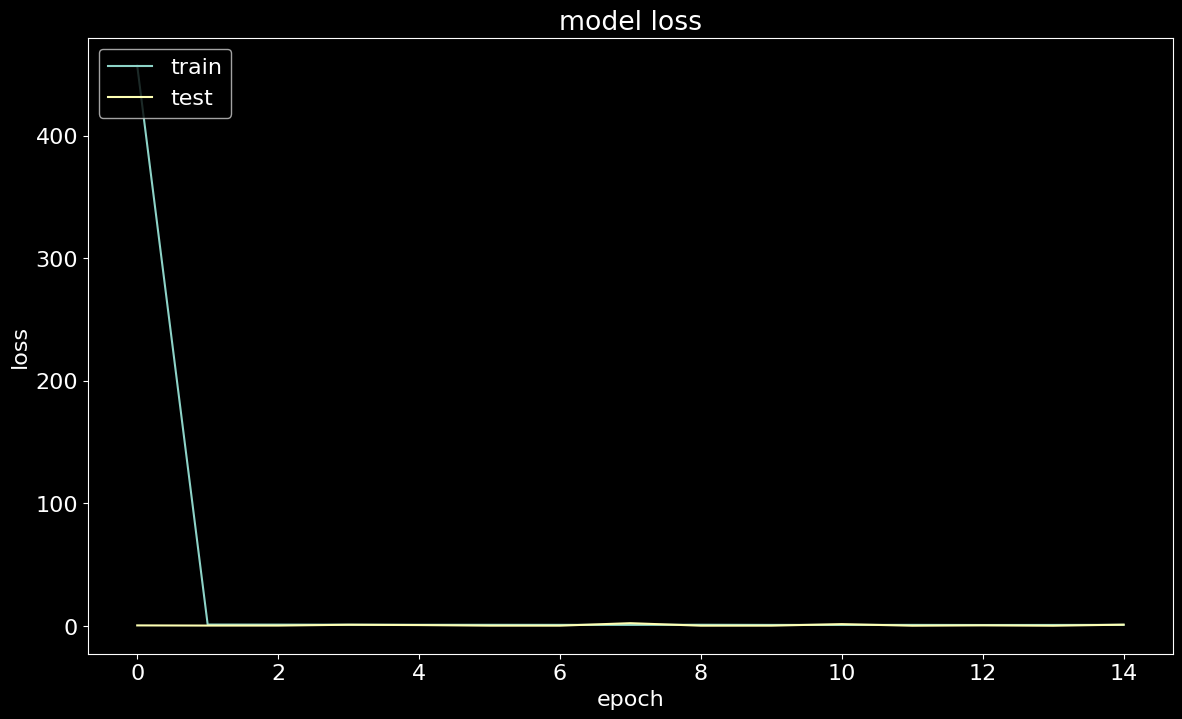

In [300]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [301]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
Shape of train and test predict:  (2490, 1) (618, 1)


In [302]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

def measure_mape(actual, predicted):
    return math.sqrt(mean_absolute_percentage_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

train_score_mape = measure_mape(train_y, train_predict)
test_score_mape = measure_mape(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)
print('Train and Test MAPE: ', train_score_mape, test_score_mape)

Train and Test RMSE:  1.1325696068968467 2.7914005690613584
Train and Test MAPE:  0.11933074227971509 0.14485149764886948


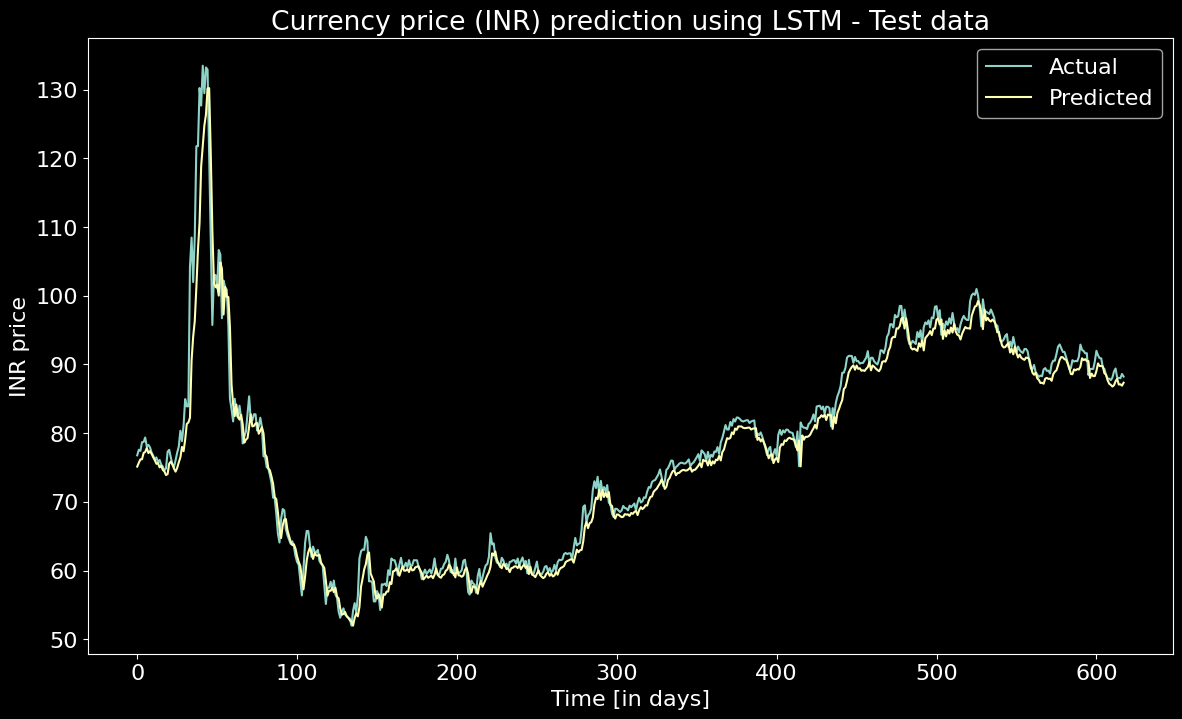

In [303]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

In [304]:
train_predict

array([[41.383465],
       [42.165985],
       [42.65526 ],
       ...,
       [74.78692 ],
       [74.6845  ],
       [74.0484  ]], dtype=float32)

In [305]:
test_predict_np = test_predict.reshape((len(test_predict)))

In [306]:
test_predict_np.shape

(618,)

In [307]:
test_predict_random = test_data.close.to_numpy()

In [308]:
test_data.close

date
2022-01-12    74.5280
2022-01-13    76.2575
2022-01-14    76.2366
2022-01-16    76.4480
2022-01-17    76.1631
               ...   
2024-01-19    88.0500
2024-01-21    88.0500
2024-01-22    87.9932
2024-01-23    88.6173
2024-01-24    88.2400
Name: close, Length: 625, dtype: float64

In [309]:
test_predict_random = pd.Series(test_y).shift(1).fillna(test_y[0])

In [310]:
test_predict_random.shape

(618,)

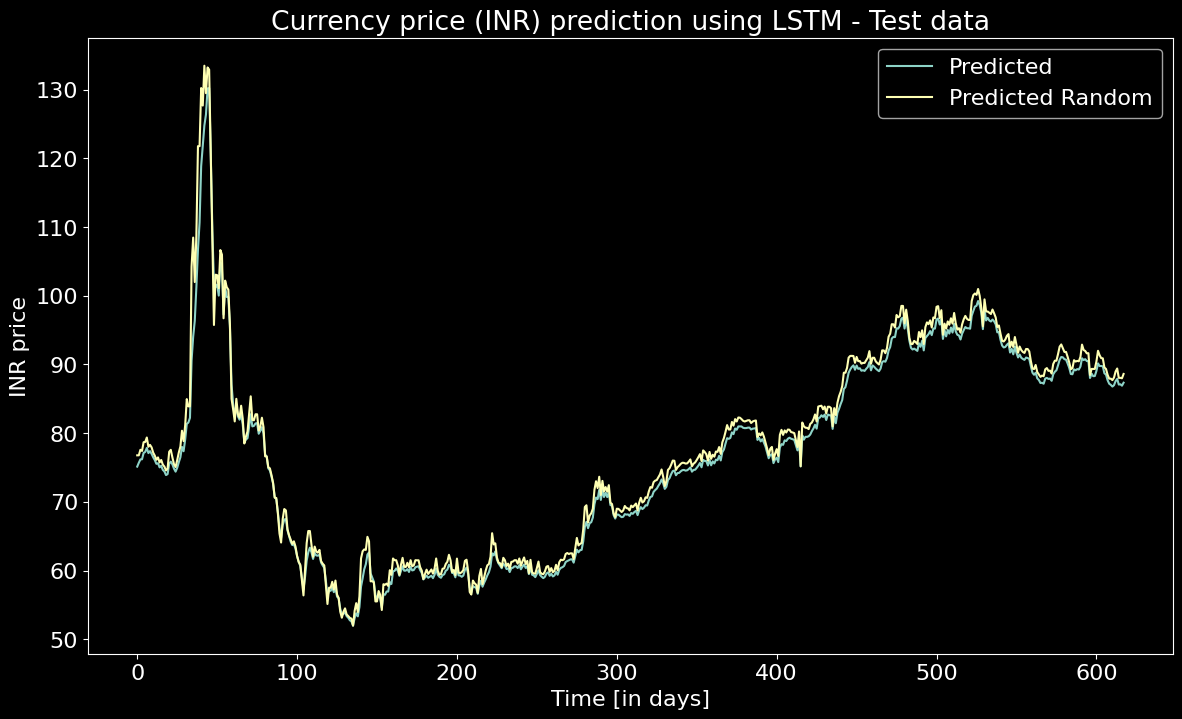

In [311]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_predict_np, label = 'Predicted')
plt.plot(test_predict_random, label = 'Predicted Random')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

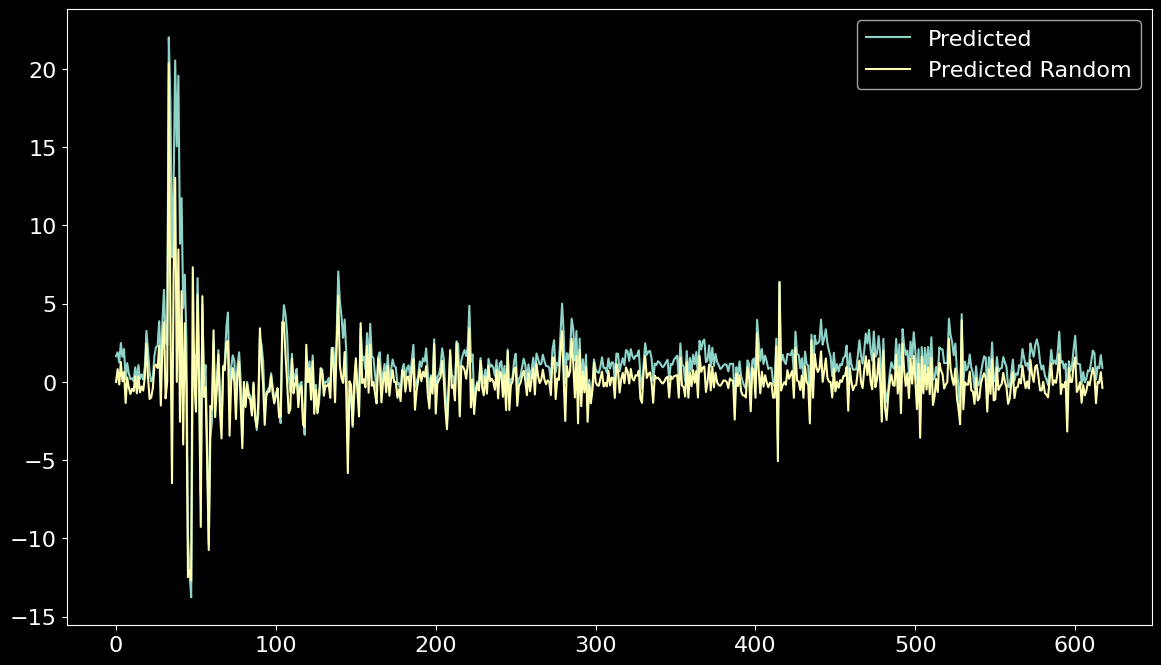

In [312]:
#Errors 
plt.plot(test_y -test_predict_np,label = 'Predicted')
plt.plot(test_y -test_predict_random, label = 'Predicted Random')
plt.legend()

In [313]:
(test_y - test_predict).mean()

1.1748892396698494

In [314]:
(test_y - test_predict_random).mean()

0.01855970873786407

Check predictions

In [315]:
type(test_X)

numpy.ndarray

In [316]:
test_X

array([[[74.528 ],
        [76.2575],
        [76.2366],
        ...,
        [76.1631],
        [76.8433],
        [76.156 ]],

       [[76.2575],
        [76.2366],
        [76.448 ],
        ...,
        [76.8433],
        [76.156 ],
        [76.7701]],

       [[76.2366],
        [76.448 ],
        [76.1631],
        ...,
        [76.156 ],
        [76.7701],
        [77.58  ]],

       ...,

       [[87.938 ],
        [87.7218],
        [88.086 ],
        ...,
        [89.414 ],
        [88.05  ],
        [88.05  ]],

       [[87.7218],
        [88.086 ],
        [88.976 ],
        ...,
        [88.05  ],
        [88.05  ],
        [87.9932]],

       [[88.086 ],
        [88.976 ],
        [89.414 ],
        ...,
        [88.05  ],
        [87.9932],
        [88.6173]]])

In [317]:
data_X, data_y = split_sequence(data['close'], lag)

C:\Users\igor\AppData\Local\Temp\ipykernel_21872\1544843132.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


In [318]:
data_X = data_X.reshape((data_X.shape[0], data_X.shape[1], n_features))

In [319]:
model.predict(data_X)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


array([[41.383465],
       [42.165985],
       [42.65526 ],
       ...,
       [87.11668 ],
       [86.90685 ],
       [87.34513 ]], dtype=float32)

In [320]:
data2 = data[3:]

In [321]:
len(model.predict(data_X))

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


3115

In [322]:
# data2['lstm_predict'] = model.predict(data_X)

In [323]:
data2

,open,high,low,close,vol
date,,,,,
2014-10-07,39.7165,39.9751,39.6550,39.8873,376
2014-10-08,39.8959,40.1560,39.6877,39.9721,901
2014-10-31,41.4547,43.1366,41.4072,43.0322,95184
2014-11-01,42.9971,43.0322,42.9971,43.0233,29
2014-11-03,43.1758,43.6175,43.1471,43.5873,163475
...,...,...,...,...,...
2024-01-19,89.4213,89.5250,87.1000,88.0500,7931
2024-01-21,88.0500,88.0500,88.0500,88.0500,2
2024-01-22,88.0500,88.5650,86.9250,87.9932,2622
